## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflo

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
#建立神經網路
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 載入 Callbacks
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
設定 callbacks: Earlystop

————————————————
min_delta：增大或减小的阈值，只有大于这个部分才算作improvement。
这个值的大小取决于monitor，也反映了你的容忍程度。例如笔者的monitor是’acc’
，同时其变化范围在70%-90%之间，所以对于小于0.01%的变化不关心。
加上观察到训练过程中存在抖动的情况（即先下降后上升），所以适当增大容忍程度，最终设为0.003%。

patience：能够容忍多少个epoch内都没有improvement。
这个设置其实是在抖动和真正的准确率下降之间做tradeoff。如果patience设的大，
那么最终得到的准确率要略低于模型可以达到的最高准确率。如果patience设的小，那么模型很可能在前期抖动
，还在全图搜索的阶段就停止了，准确率一般很差。patience的大小和learning rate直接相关。
在learning rate设定的情况下，前期先训练几次观察抖动的epoch number
，比其稍大些设置patience。在learning rate变化的情况下，建议要略小于最大的抖动epoch number
。笔者在引入EarlyStopping之前就已经得到可以接受的结果了，EarlyStopping算是锦上添花
，所以patience设的比较高，设为抖动epoch number的最大值。
————————————————

"""


'\n# 載入 Callbacks, 並將 monitor 設定為監控 validation loss\n設定 callbacks: Earlystop\n\n————————————————\nmin_delta：增大或减小的阈值，只有大于这个部分才算作improvement。\n这个值的大小取决于monitor，也反映了你的容忍程度。例如笔者的monitor是’acc’\n，同时其变化范围在70%-90%之间，所以对于小于0.01%的变化不关心。\n加上观察到训练过程中存在抖动的情况（即先下降后上升），所以适当增大容忍程度，最终设为0.003%。\n\npatience：能够容忍多少个epoch内都没有improvement。\n这个设置其实是在抖动和真正的准确率下降之间做tradeoff。如果patience设的大，\n那么最终得到的准确率要略低于模型可以达到的最高准确率。如果patience设的小，那么模型很可能在前期抖动\n，还在全图搜索的阶段就停止了，准确率一般很差。patience的大小和learning rate直接相关。\n在learning rate设定的情况下，前期先训练几次观察抖动的epoch number\n，比其稍大些设置patience。在learning rate变化的情况下，建议要略小于最大的抖动epoch number\n。笔者在引入EarlyStopping之前就已经得到可以接受的结果了，EarlyStopping算是锦上添花\n，所以patience设的比较高，设为抖动epoch number的最大值。\n————————————————\n\n'

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
STOP_STEP=[5,10,25]

In [8]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for step in STOP_STEP:
    print("early stop step:",step)
    earlystop = EarlyStopping(monitor="val_accuracy", patience=step, verbose=1)

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]


    exp_name_tag ="EarlyStop Step=%s" % str(step)


    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

early stop step: 5
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 52us/step - loss: 2.1939 - accuracy: 0.2682 - val_loss: 2.1128 - val_accuracy: 0.2520
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.7516 - accuracy: 0.3873 - val_loss: 1.9579 - val_accuracy: 0.3087
Epoch 3/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.6286 - accuracy: 0.4295 - val_loss: 1.8425 - val_accuracy: 0.3693
Epoch 4/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.5535 - accuracy: 0.4561 - val_loss: 1.7435 - val_accuracy: 0.4001
Epoch 5/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.5009 - accuracy: 0.4748 - val_loss: 1.6543 - val_accuracy: 0.4261
Epoch 6/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.4545 - accuracy: 0.4910 - val_loss: 1.6054 - val_accuracy: 0.4418
Epoch 7/50
50000/50000 [==============================] - 2s 41us/st

50000/50000 [==============================] - 3s 54us/step - loss: 2.1823 - accuracy: 0.2787 - val_loss: 2.1182 - val_accuracy: 0.2209
Epoch 2/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.7332 - accuracy: 0.3947 - val_loss: 1.9623 - val_accuracy: 0.3127
Epoch 3/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.6126 - accuracy: 0.4375 - val_loss: 1.8106 - val_accuracy: 0.3748
Epoch 4/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.5388 - accuracy: 0.4633 - val_loss: 1.7123 - val_accuracy: 0.4049
Epoch 5/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.4849 - accuracy: 0.4845 - val_loss: 1.6444 - val_accuracy: 0.4256
Epoch 6/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.4388 - accuracy: 0.5005 - val_loss: 1.5822 - val_accuracy: 0.4505
Epoch 7/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.3995 - accuracy: 0.5150 - val_loss: 1.5391 - val

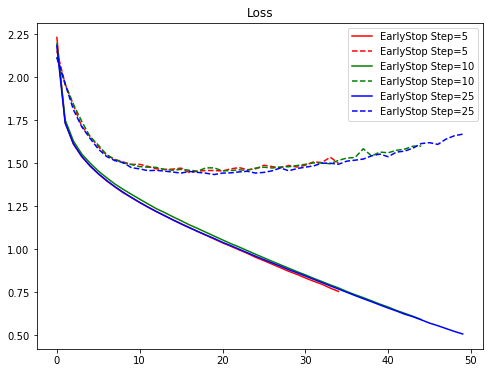

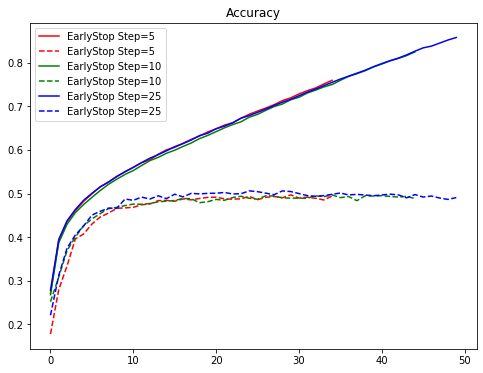

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'#eeefff','#00efff']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()